In [1]:
# Survival analyses for REVISION
# 10-29-2022
# Esther Rheinbay

import sys, re
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

import time

%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
fig_dir = '.'

<h3> Load TCGA sample info table and Y status calls from supplementary tables </h3>

In [3]:
# General sample info from https://gdc.cancer.gov/about-data/publications/pancanatlas
TCGA_sample_info = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
TCGA_survival = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)


In [4]:
# All calls from supplementary tables
male_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name = 'Supp_Table_1', header=0, index_col=0)
female_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name = 'Supp_Table_2', header=0, index_col=0)

# Filter out samples with discordant annotated gender and genomic sex
male_CNV_calls_filtered = male_CNV_calls[~male_CNV_calls.Flag.isin(['sex_discordant_or_ambiguous_copy_number_sex_chromsome', 'low_quality'])]
female_CNV_calls_filtered = female_CNV_calls[~female_CNV_calls.Flag.isin(['sex_discordant_or_ambiguous_copy_number_sex_chromsome', 'low_quality'])]


In [5]:
TCGA_sample_info['Y_status'] = TCGA_sample_info.apply(lambda x: male_CNV_calls_filtered.loc[x.name]['Y_status'] if x.name in male_CNV_calls_filtered.index else 'NA', axis=1)
TCGA_sample_info['X_status'] = TCGA_sample_info.apply(lambda x: female_CNV_calls_filtered.loc[x.name]['X_status'] if x.name in female_CNV_calls_filtered.index else 'NA', axis=1)

<h3> Calculate fraction of LOY tumors within each tumor type </h3>

In [6]:
# Calculate the fraction LOY across tumor types in males
tumor_types_male  = (supp_table_male[['Cohort','Y_status']].value_counts(sort=False)/supp_table_male[['Cohort']].value_counts(sort=False)).unstack()
tumor_types_male.replace(np.nan, 0, inplace=True)
tumor_types_male.columns.name = None
tumor_types_male.index.name = None
tumor_types_male['sample_counts'] = tumor_types_male.apply(lambda x: supp_table_male[['Cohort']].value_counts()[x.name], axis=1)

# remove BRCA, only 11 tumors 
tumor_types_male.drop('BRCA', inplace=True)
tumor_types_male.sort_values(by='WT', ascending=True, inplace=True)

df=tumor_types_male[['WT', 'LOY', 'rLOY', 'pLOY', 'Gain_Loss', 'Gain' ]]
tumor_types_male.sort_values(by='LOY', ascending=False)


,Gain,Gain_Loss,LOY,WT,pLOY,rLOY,sample_counts
KIRP,0.004739,0.004739,0.791469,0.180095,0.000000,0.009479,211
ESCA,0.025478,0.025478,0.566879,0.254777,0.114650,0.006369,157
KICH,0.000000,0.000000,0.512821,0.435897,0.025641,0.000000,39
PAAD,0.029703,0.000000,0.475248,0.475248,0.009901,0.009901,101
UVM,0.022222,0.000000,0.466667,0.511111,0.000000,0.000000,45
STAD,0.024735,0.017668,0.466431,0.427562,0.035336,0.024735,283
CHOL,0.000000,0.000000,0.437500,0.562500,0.000000,0.000000,16
ACC,0.000000,0.031250,0.437500,0.468750,0.031250,0.000000,32
LUSC,0.062842,0.038251,0.420765,0.357923,0.087432,0.027322,366
KIRC,0.006116,0.000000,0.418960,0.553517,0.000000,0.009174,327


<h3> Load genome instability values from Taylor et al, 2018 (Table S2) </h3>

In [7]:
# association of LOY with overall genomic instability 
genome_instability_values = pd.read_excel('1-s2.0-S1535610818301119-mmc2.xlsx', sheet_name=0,header=0,skiprows=1, index_col=0)
genome_instability_values['case_id'] = genome_instability_values.index
genome_instability_values.index = [x[0:12] for x in genome_instability_values.index]
genome_instability_values['tumor_type'] = genome_instability_values.apply(lambda x: TCGA_sample_info.loc[x.name]['type'] if x.name in TCGA_sample_info.index else 'NA', axis=1)
genome_instability_values['Y_status'] = genome_instability_values.apply(lambda x: 'NA' if not x.case_id in supp_table_male.case_tcga_sample_id.to_list() else supp_table_male[supp_table_male.case_tcga_sample_id==x.case_id].Y_status[0], axis=1)
genome_instability_values['X_status'] = genome_instability_values.apply(lambda x: 'NA' if not x.case_id in supp_table_female.case_tcga_sample_id.to_list() else supp_table_female[supp_table_female.case_tcga_sample_id==x.case_id].X_status[0], axis=1)
genome_instability_values_males = genome_instability_values.loc[[x for x in supp_table_male.index if x in genome_instability_values.index]]
genome_instability_values_females = genome_instability_values.loc[[x for x in supp_table_female.index if x in genome_instability_values.index]]



In [8]:
# Annotate and code LOY and WT into binary variable for regression models
TCGA_survival['Y_status'] = TCGA_survival.apply(lambda x: TCGA_sample_info.Y_status[x.name], axis=1)
TCGA_survival['Y_coded'] = TCGA_survival.apply(lambda x: 1 if x.Y_status=='LOY' else (0 if x.Y_status=='WT' else np.nan), axis=1)


<h3> Kaplan-Meier plot for all LOY vs WT tumors </h3>

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.54 <0.005      9.74

<lifelines.CoxPHFitter: fitted with 4271 total observations, 2315 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS'
      baseline estimation = breslow
   number of observations = 4271
number of events observed = 1956
   partial log-likelihood = -14908.74
         time fit was run = 2023-01-09 21:05:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Y_coded     0.15       1.17       0.05             0.06             0.25                 1.06                 1.28

             z      p   -log2(p)
covariate                       
Y_coded   3.24 <0.005       9.73
---
Concordance = 0.51
Partial AIC = 29819.47
log-likelihood ratio test = 10.36 on 1 df
-log2(p) of ll-ratio test = 9.60

Text(5, 0.1, 'HR = 1.17')

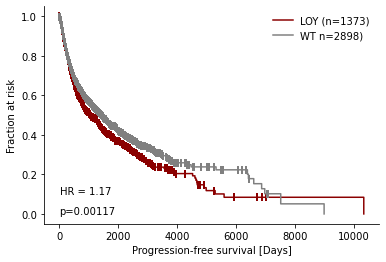

In [9]:
# survival analysis for all of TCGA- yes, of course this is dependent on tumor types

PFS_time = TCGA_survival['PFS.time']
status = TCGA_survival['PFS']

LOY_samples = TCGA_sample_info[(TCGA_sample_info.Y_status=='LOY') & (TCGA_sample_info.gender=='MALE')].index
wtY_samples = TCGA_sample_info[(TCGA_sample_info.Y_status=='WT') & (TCGA_sample_info.gender=='MALE')].index

# Split (male) patients into low_Y and other - one patient not included due to NaN PFS_time, but is included in UVM clinical table?
TCGA_LOY = PFS_time.loc[[x for x in PFS_time.index.values if x in LOY_samples]].dropna().index.values
TCGA_wtY = PFS_time.loc[[x for x in PFS_time.index.values if x in wtY_samples]].dropna().index.values

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
k1 = kmf.fit(PFS_time[TCGA_LOY], status[TCGA_LOY],label='LOY (n=' + str(len(PFS_time[TCGA_LOY]))+')')

# plot first curve
ax = k1.plot(ci_show=False, color="darkred", show_censors=True, censor_styles={"marker": "|", "ms": 8, "mew":2}) 
ax.set_ylabel('Fraction at risk')
k2 = kmf.fit(PFS_time[TCGA_wtY].dropna(), status[TCGA_wtY].dropna(),label='WT n=' + str(len(PFS_time[TCGA_wtY])) + ')')
# plot second curve
k2.plot(ax=ax, color='grey', ci_show=False, show_censors=True, censor_styles={"marker": "|", "ms": 8, "mew":2})
# log-rank test
test = logrank_test(PFS_time[TCGA_LOY], PFS_time[TCGA_wtY], status[TCGA_LOY], status[TCGA_wtY], alpha=.99)
test.print_summary()
ax.text(5, 0.0, "p=" + str(round(test.p_value,5)))
ax.set_xlabel('Progression-free survival [Days]')
ax.legend(loc='upper right', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir +'pancancer_LOY_KM.pdf')

# calculate hazard ratio with Cox model
cph = CoxPHFitter()
cph_pfs_males = TCGA_survival.loc[[x for x in TCGA_survival.index if x in supp_table_male.index]][['Y_coded', 'PFS.time' ,'PFS']].dropna()
cph_pfs_males.dropna(inplace=True)
cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
cph.print_summary()
ax.text(5,0.1, 'HR = ' + str(round(cph.hazard_ratios_['Y_coded'], 2)))


<h3> Pan-cancer Kaplan-Meier analysis by stage </h3>

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.08 0.04      4.53

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.41 0.12      3.05

<lifelines.CoxPHFitter: fitted with 1716 total observations, 1028 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS'
      baseline estimation = breslow
   number of observations = 1716
number of events observed = 688
   partial log-likelihood = -4560.18
         time fit was run = 2023-01-09 21:05:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Y_coded     0.15       1.17       0.08             0.00             0.30                 1.00                 1.36

             z    p   -log2(p)
covariate                     
Y_coded   2.02 0.04       4.52
---
Concordance = 0.52
Partial AIC = 9122.37
log-likelihood ratio test = 4.06 on 1 df
-log2(p) of ll-ratio test = 4.51

<lifelines.CoxPHFitter: fitted with 1164 total observations, 469 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS'
      baseline estimation = breslow
   number of observations = 1164
number of events observed = 695
   partial log-likelihood = -4414.46
         time fit was run = 2023-01-09 21:05:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Y_coded     0.12       1.13       0.08            -0.03             0.27                 0.97                 1.31

             z    p   -log2(p)
covariate                     
Y_coded   1.55 0.12       3.05
---
Concordance = 0.51
Partial AIC = 8830.93
log-likelihood ratio test = 2.39 on 1 df
-log2(p) of ll-ratio test = 3.03

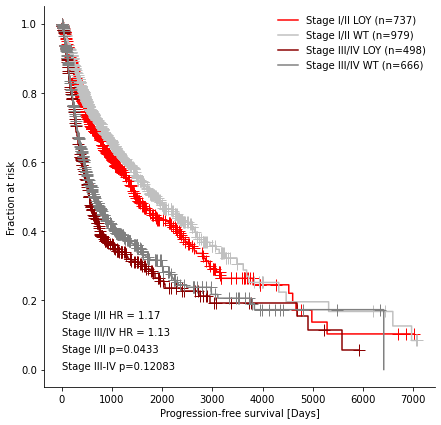

In [10]:
# analysis by stage
# group together I/II and III/IV for more power

# Stage I/II definitions
stageI_II = ['Stage I', 'Stage IA', 'Stage IB', 'Stage II', 'Stage IIA','Stage IIB', 'Stage IIC']

# Stage III/IV definitions
stageIII_IV = ['Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC','Stage IV', 'Stage IVA', 'Stage IVB', 'Stage IVC']

# Split into LOY and WT samples
stageI_II_LOY = TCGA_sample_info[(TCGA_sample_info.Y_status=='LOY') & (TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.ajcc_pathologic_tumor_stage.isin(stageI_II))].index
stageI_II_WT = TCGA_sample_info[(TCGA_sample_info.Y_status=='WT') & (TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.ajcc_pathologic_tumor_stage.isin(stageI_II))].index


stageIII_IV_LOY = TCGA_sample_info[(TCGA_sample_info.Y_status=='LOY') & (TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.ajcc_pathologic_tumor_stage.isin(stageIII_IV))].index
stageIII_IV_WT = TCGA_sample_info[(TCGA_sample_info.Y_status=='WT') & (TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.ajcc_pathologic_tumor_stage.isin(stageIII_IV))].index

# Reduce to those that have PFS
TCGA_LOY_stageI_II = PFS_time.loc[[x for x in PFS_time.index.values if x in stageI_II_LOY]].dropna().index.values
TCGA_wtY_stageI_II = PFS_time.loc[[x for x in PFS_time.index.values if x in stageI_II_WT]].dropna().index.values

TCGA_LOY_stageIII_IV = PFS_time.loc[[x for x in PFS_time.index.values if x in stageIII_IV_LOY]].dropna().index.values
TCGA_wtY_stageIII_IV = PFS_time.loc[[x for x in PFS_time.index.values if x in stageIII_IV_WT]].dropna().index.values


## create a kmf object
kmf = KaplanMeierFitter() 


fig, ax = plt.subplots(1,1, figsize = (7,7))
# plot first curve
k1 = kmf.fit(PFS_time[TCGA_LOY_stageI_II], status[TCGA_LOY_stageI_II],label='Stage I/II LOY (n=' + str(len(PFS_time[TCGA_LOY_stageI_II]))+')')
ax = k1.plot(ci_show=False, color="red", show_censors=True) 

# plot second curve
k2 = kmf.fit(PFS_time[TCGA_wtY_stageI_II].dropna(), status[TCGA_wtY_stageI_II].dropna(),label='Stage I/II WT (n=' + str(len(PFS_time[TCGA_wtY_stageI_II])) + ')')
k2.plot(ax=ax, color='silver', ci_show=False, show_censors=True)

# log-rank test for stageI/II LOY/WT difference
test = logrank_test(PFS_time[TCGA_LOY_stageI_II], PFS_time[TCGA_wtY_stageI_II], status[TCGA_LOY_stageI_II], status[TCGA_wtY_stageI_II], alpha=.99)
test.print_summary()
ax.text(5, 0.05, "Stage I/II p=" + str(round(test.p_value,5)))

# add stage III/IV curves
k3 = kmf.fit(PFS_time[TCGA_LOY_stageIII_IV], status[TCGA_LOY_stageIII_IV],label='Stage III/IV LOY (n=' + str(len(PFS_time[TCGA_LOY_stageIII_IV]))+')')
ax = k3.plot(ci_show=False, color="darkred", show_censors=True) 
k4 = kmf.fit(PFS_time[TCGA_wtY_stageIII_IV].dropna(), status[TCGA_wtY_stageIII_IV].dropna(),label='Stage III/IV WT (n=' + str(len(PFS_time[TCGA_wtY_stageIII_IV])) + ')')
k4.plot(ax=ax, color='grey', ci_show=False, show_censors=True)

# log-rank test for stage III/IV
test = logrank_test(PFS_time[TCGA_LOY_stageIII_IV], PFS_time[TCGA_wtY_stageIII_IV], status[TCGA_LOY_stageIII_IV], status[TCGA_wtY_stageIII_IV], alpha=.99)
test.print_summary()

ax.text(5, 0.0, "Stage III-IV p=" + str(round(test.p_value,5)))
ax.set_ylabel('Fraction at risk')
ax.set_xlabel('Progression-free survival [Days]')
ax.legend(loc='upper right', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# calculate hazard ratio with Cox model for stage I/II
cph = CoxPHFitter()
cph_pfs_males = TCGA_survival.loc[[x for x in TCGA_survival.index if x in supp_table_male.index and x in np.append(TCGA_LOY_stageI_II,TCGA_wtY_stageI_II)]][['Y_status', 'PFS.time' ,'PFS']].dropna()
cph_pfs_males['Y_coded'] = cph_pfs_males.apply(lambda x: 1 if x.Y_status=='LOY' else (0 if x.Y_status=='WT' else np.nan), axis=1)
cph_pfs_males.dropna(inplace=True)
cph_pfs_males.drop(columns=['Y_status'], inplace=True)
cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
cph.print_summary()
ax.text(5,0.15, 'Stage I/II HR = ' + str(round(cph.hazard_ratios_['Y_coded'], 2)))

# calculate hazard ratio with Cox model for stage III/IV
cph = CoxPHFitter()
cph_pfs_males = TCGA_survival.loc[[x for x in TCGA_survival.index if x in supp_table_male.index and x in np.append(TCGA_LOY_stageIII_IV,TCGA_wtY_stageIII_IV)]][['Y_status', 'PFS.time' ,'PFS']].dropna()
cph_pfs_males['Y_coded'] = cph_pfs_males.apply(lambda x: 1 if x.Y_status=='LOY' else (0 if x.Y_status=='WT' else np.nan), axis=1)
cph_pfs_males.dropna(inplace=True)
cph_pfs_males.drop(columns=['Y_status'], inplace=True)
cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
cph.print_summary()
ax.text(5,0.1, 'Stage III/IV HR = ' + str(round(cph.hazard_ratios_['Y_coded'], 2)))

plt.savefig(fig_dir +'pancancer_LOY_by_stage_KM.pdf')



<h3> Evaluate effect of age  for each tumor type </h3>

In [11]:
# add age at diagnosis to dataframe
TCGA_survival['Age_at_diagnosis'] = TCGA_survival.apply(lambda x: TCGA_sample_info.loc[x.name]['age_at_initial_pathologic_diagnosis'], axis=1)

KIRP
ESCA
LUSC
HNSC
STAD
KICH
LUAD
ACC
PAAD
READ
BLCA
UVM
COAD
DLBC
KIRC
CHOL
SARC
SKCM
MESO
LIHC
TGCT
GBM
LGG
PRAD
THYM
PCPG
THCA
LAML


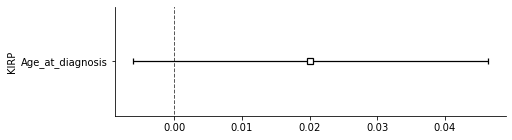

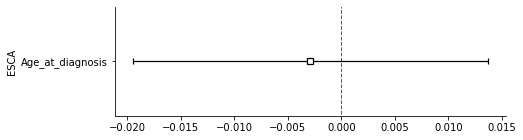

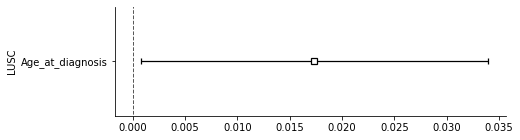

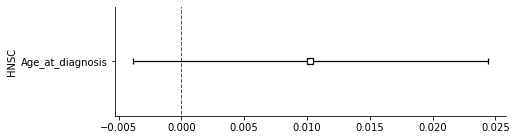

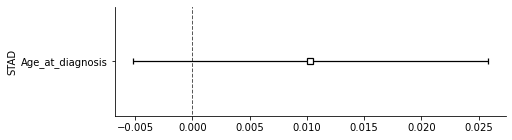

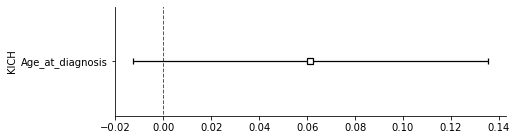

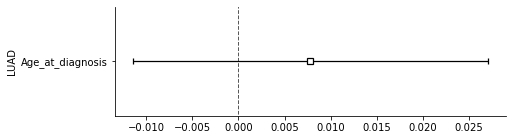

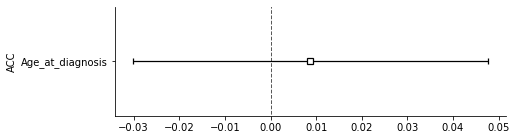

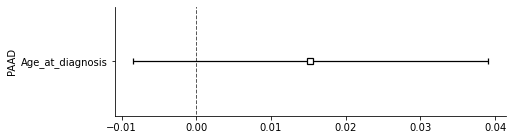

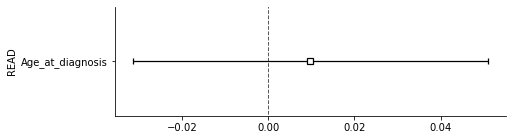

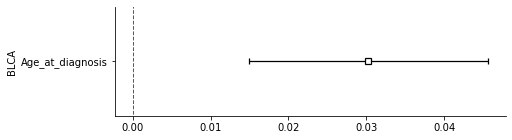

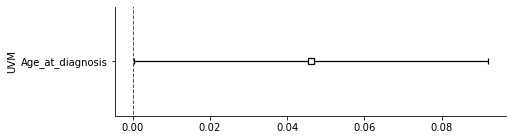

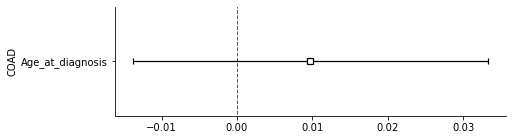

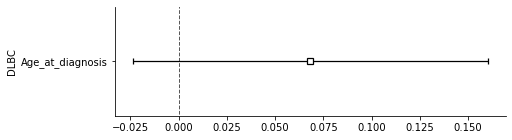

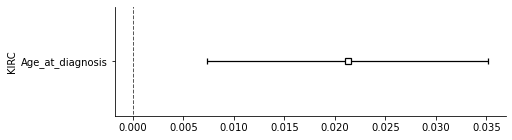

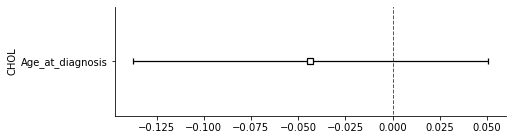

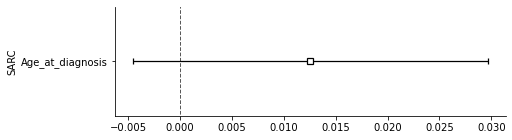

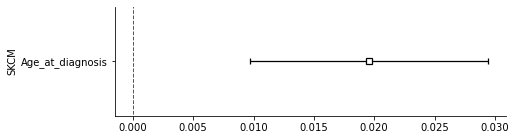

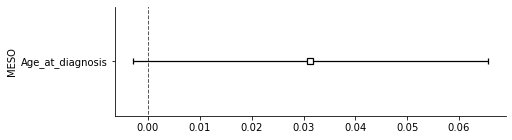

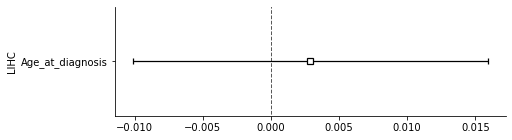

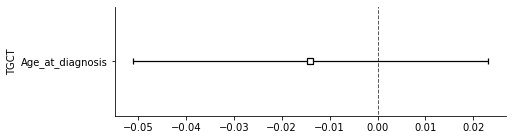

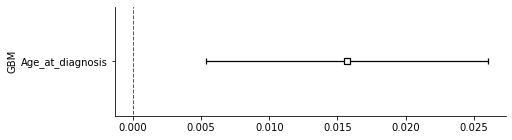

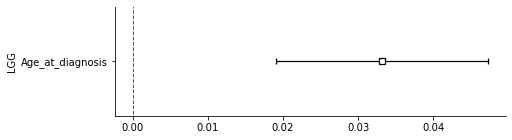

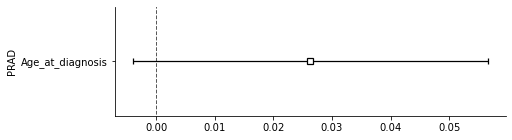

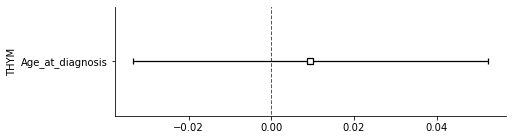

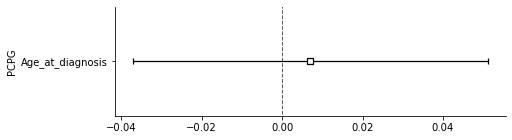

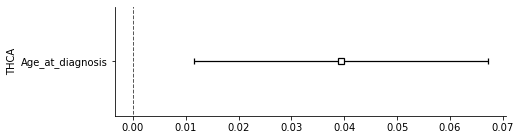

In [12]:
# Cox regression model to evaluate age at diagnosis effect on survival alone
survival_pvalues = pd.DataFrame(index = tumor_types_male.index, columns = ['age_HR', 'age_Cox_p'])

for t in tumor_types_male.index.values:
    print(t)
    if t in ['LAML']:
        continue

    cph = CoxPHFitter()
    cph_pfs_males = TCGA_survival.loc[[x for x in TCGA_survival.index if ((x in supp_table_male.index) & (x in TCGA_survival[TCGA_survival.type==t].index))]][['PFS.time' ,'PFS','Age_at_diagnosis']]    
    cph_pfs_males.dropna(inplace=True)
    cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
    survival_pvalues.loc[t]['age_HR'] = cph.hazard_ratios_['Age_at_diagnosis']
    survival_pvalues.loc[t]['age_Cox_p'] = cph.summary['p'][0]
    fig, ax = plt.subplots(1, 1, figsize=(7, 2))
    cph.plot(hazard_ratios=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(t)
    ax.set_xlabel('')
 

In general effect of age is very small

<h3> Regression model combining LOY, age and aneuploidy (specifically number of chromosome losses) </h3>

In [13]:
# Cox regression model with age at diagnosis and measure of aneuploidy
# add scores to survival dataframe

d = genome_instability_values.merge(supp_table_male, left_on = 'case_id', right_on = 'case_tcga_sample_id', how= 'right')
d.index= supp_table_male.index

TCGA_survival['AS_del'] = TCGA_survival.apply(lambda x: d.loc[x.name].AS_del if x.name in d.index else np.nan,axis=1)
TCGA_survival['AneuploidyScore(AS)'] = TCGA_survival.apply(lambda x: d.loc[x.name]['AneuploidyScore(AS)'] if x.name in d.index else np.nan,axis=1)


In [14]:
# Cox regression model for arms lost + LOY + age
survival_pvalues['age_LOY_AS_del_HR_AS'] = ''
survival_pvalues['age_LOY_AS_del_Cox_p_AS'] = ''
survival_pvalues['age_LOY_AS_del_HR_LOY'] = ''
survival_pvalues['age_LOY_AS_del_Cox_p_LOY'] = ''
survival_pvalues['age_LOY_AS_del_HR_age'] = ''
survival_pvalues['age_LOY_AS_del_Cox_p_age'] = ''

for t in tumor_types_male.index.values:
    print(t)
    
    # remove tumor types with too few samples in either group (or total)
    if t in ['BRCA', 'PCPG','LAML']:
        continue
    cph = CoxPHFitter()
    cph_pfs_males = TCGA_survival.loc[[x for x in TCGA_survival.index if ((x in supp_table_male.index) & (x in TCGA_survival[TCGA_survival.type==t].index))]][['PFS.time' ,'PFS', 'AS_del', 'Y_coded', 'Age_at_diagnosis']].dropna()
    cph_pfs_males.dropna(inplace=True)
    cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
    survival_pvalues.loc[t]['age_LOY_AS_del_HR_AS'] = cph.hazard_ratios_['AS_del']
    survival_pvalues.loc[t]['age_LOY_AS_del_Cox_p_AS'] = cph.summary['p']['AS_del']
    survival_pvalues.loc[t]['age_LOY_AS_del_HR_LOY'] = cph.hazard_ratios_['Y_coded']
    survival_pvalues.loc[t]['age_LOY_AS_del_Cox_p_LOY'] = cph.summary['p']['Y_coded']
    survival_pvalues.loc[t]['age_LOY_AS_del_HR_age'] = cph.hazard_ratios_['Age_at_diagnosis']
    survival_pvalues.loc[t]['age_LOY_AS_del_Cox_p_age'] = cph.summary['p']['Age_at_diagnosis']
   

KIRP
ESCA
LUSC
HNSC
STAD
KICH
LUAD
ACC
PAAD
READ
BLCA
UVM
COAD
DLBC
KIRC
CHOL
SARC
SKCM
MESO
LIHC
TGCT
GBM
LGG
PRAD
THYM
PCPG
THCA
LAML


<h3> Make combined forest plot </h3>

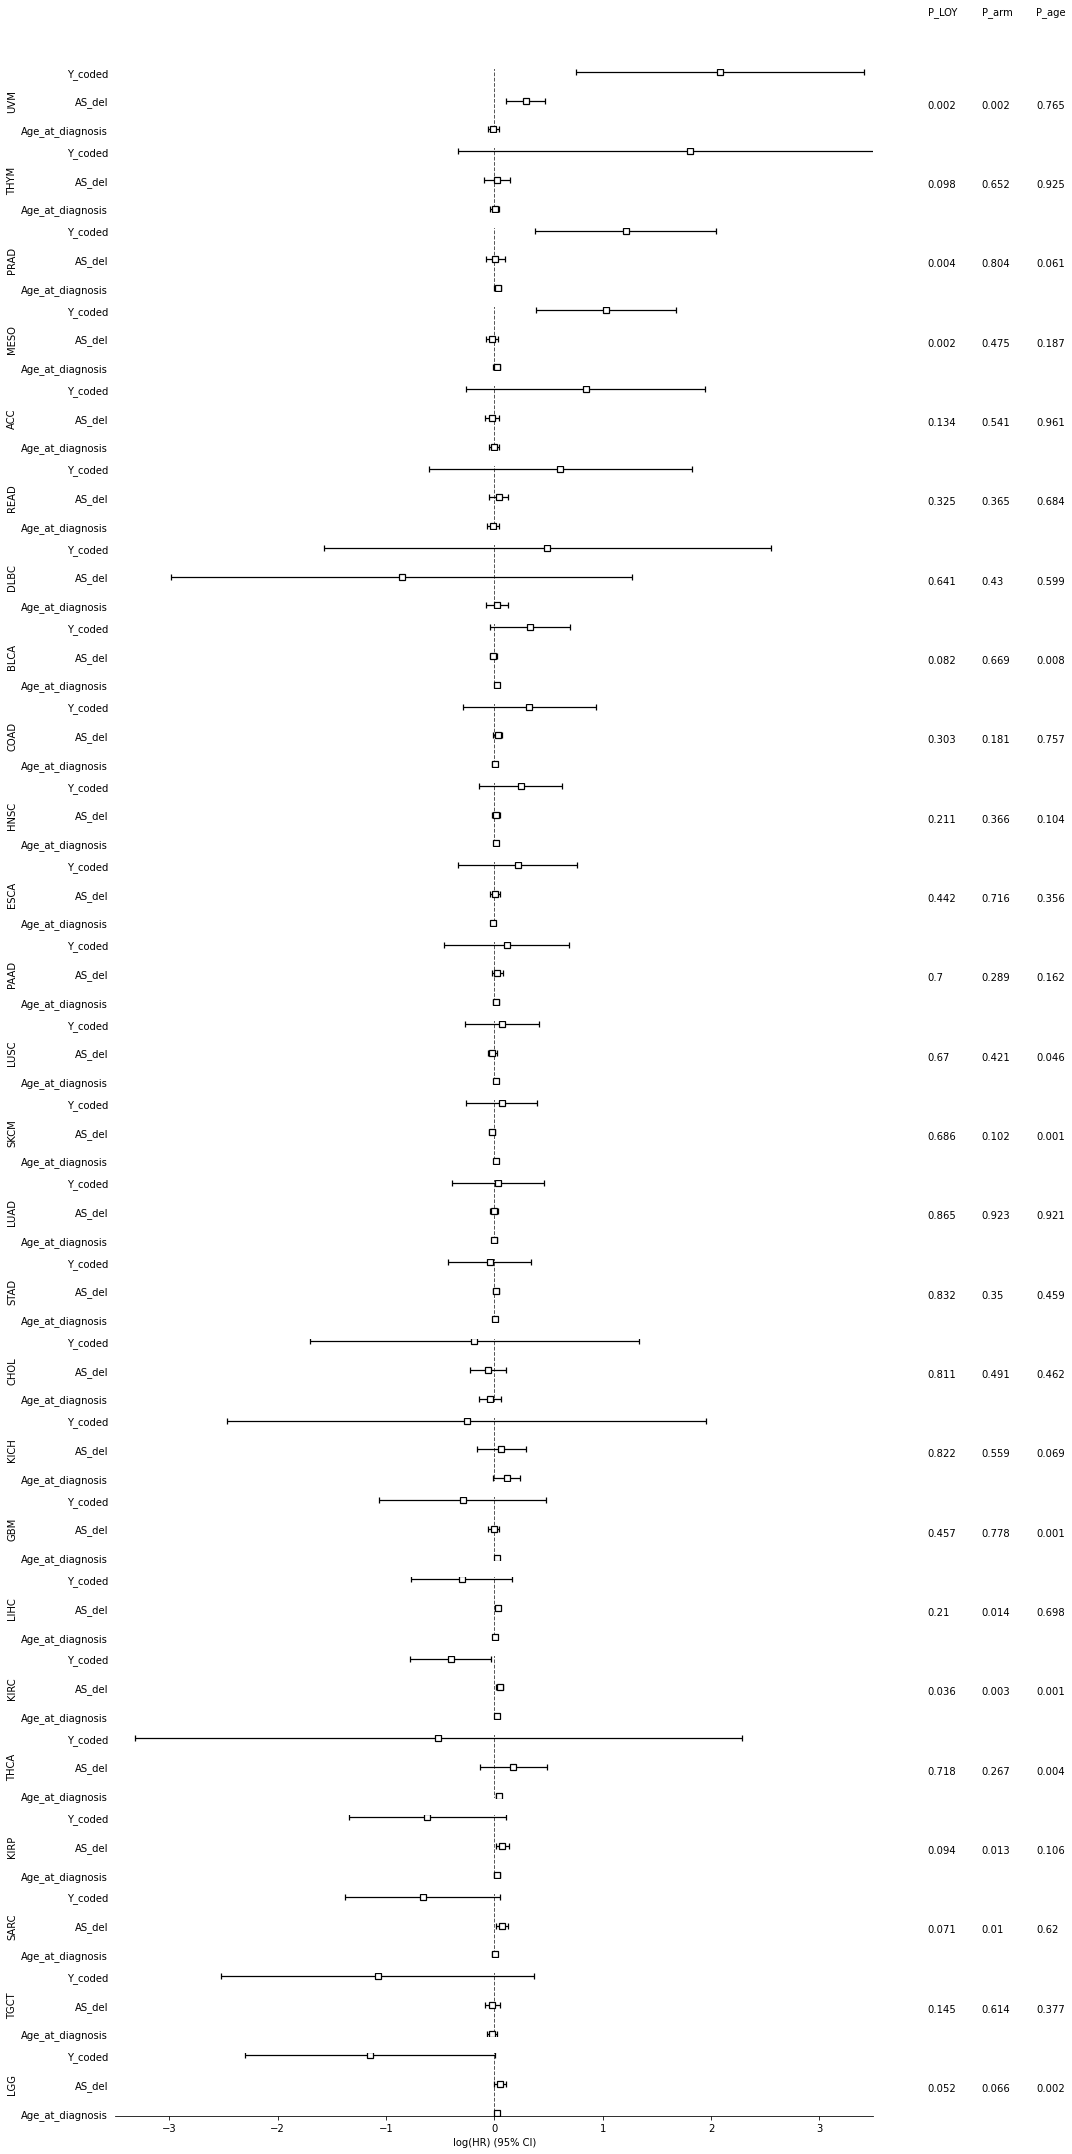

In [15]:
# Figure 4B before color editing 
# Combined forest plot for LOY, age, AS_del

plot_order = survival_pvalues.loc[[x  for x in survival_pvalues.index if x not in  ['LAML', 'BRCA', 'PCPG']]].sort_values(by = 'age_LOY_AS_del_HR_LOY', ascending=False).index
fig, ax = plt.subplots(len(plot_order),1, figsize=(15, 30))
i = 0
ax[0].text(4, 4, 'P_LOY')
ax[0].text(4.5, 4, 'P_arm')
ax[0].text(5, 4, 'P_age')

for t in plot_order:    
    if t in ['BRCA', 'PCPG','LAML']:
        continue
    cph = CoxPHFitter()
    cph_pfs_males = TCGA_survival.loc[[x for x in TCGA_survival.index if ((x in supp_table_male.index ) & (x in TCGA_survival[TCGA_survival.type==t].index))]][['PFS.time' ,'PFS', 'AS_del', 'Y_coded', 'Age_at_diagnosis']].dropna()
    cph_pfs_males.dropna(inplace=True)

    cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
    cph.plot(columns = ['Y_coded', 'AS_del', 'Age_at_diagnosis'], hazard_ratios=False, ax = ax[i])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].yaxis.set_ticks_position('none') 
    
    if (i<len(plot_order)-1):
        ax[i].spines['bottom'].set_visible(False)
        ax[i].set_xticks([])
        ax[i].set_xlabel('')
        
    ax[i].set_ylabel(t)
    ax[i].set_xlim(-3.5, 3.5)
    # add p-values next to plot
    ax[i].text(4, 0.75, round(survival_pvalues.loc[t].age_LOY_AS_del_Cox_p_LOY,3))
    ax[i].text(4.5, 0.75, round(survival_pvalues.loc[t].age_LOY_AS_del_Cox_p_AS,3))
    ax[i].text(5, 0.75, round(survival_pvalues.loc[t].age_LOY_AS_del_Cox_p_age,3))
    i+=1
    plt.tight_layout()
#plt.savefig(fig_dir + 'All_tumor_types_HR_AS_del_age_LOY' + time.strftime("%Y%m%d-%H%M%S") +'.pdf')
 

In [16]:
# Write hazard ratios and p-values to Supplementary Table 8
survival_reduced = survival_pvalues.loc[plot_order]

# FDR correction for LOY p-values (note - this would affect the CIs if we were to plot them!)
survival_reduced['age_LOY_AS_del_Cox_LOY_q']=fdrcorrection(survival_reduced.age_LOY_AS_del_Cox_p_LOY)[1]
 
survival_reduced.sort_values(by='age_LOY_AS_del_Cox_LOY_q', inplace=True)

#survival_reduced.to_csv(fig_dir + 'Cox_regression_analysis.txt', sep='\t', index=True)

# Show tumor types with LOY Q-value <0.05
survival_reduced[survival_reduced.age_LOY_AS_del_Cox_LOY_q<0.05]



,age_HR,age_Cox_p,age_LOY_AS_del_HR_AS,age_LOY_AS_del_Cox_p_AS,age_LOY_AS_del_HR_LOY,age_LOY_AS_del_Cox_p_LOY,age_LOY_AS_del_HR_age,age_LOY_AS_del_Cox_p_age,age_LOY_AS_del_Cox_LOY_q
UVM,1.047273,0.048134,1.335413,0.001938,8.025362,0.002193,0.992093,0.764691,0.028506
MESO,1.03182,0.073104,0.979945,0.475079,2.796139,0.001848,1.023223,0.186609,0.028506
PRAD,1.026659,0.089045,1.011218,0.804097,3.364811,0.004356,1.032427,0.061047,0.037754


<h3> Mapping to more intuitive columns names in Supplementary Table 8 </h3>
age_LOY_AS_del_HR_AS	->	Arm_deletions_HR <br>
age_LOY_AS_del_Cox_p_AS	->	Arm_deletions_Cox_p <br>
age_LOY_AS_del_HR_LOY	->	LOY_HR<br>
age_LOY_AS_del_Cox_p_LOY	->	LOY_Cox_p<br>
age_LOY_AS_del_HR_age	->	age_HR<br>
age_LOY_AS_del_Cox_p_age	->	age_Cox_p<br>
age_LOY_AS_del_Cox_LOY_q	->	LOY_q

<h3> Kaplan-Meier plot for three significant tumor types from above</h3>

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.32 <0.005      9.57

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.50 <0.005     11.26

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.83 <0.005     11.52

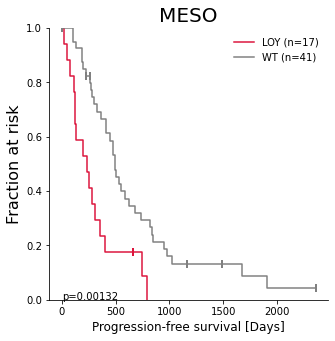

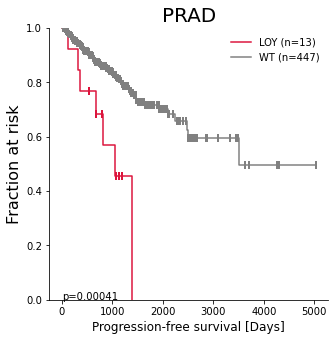

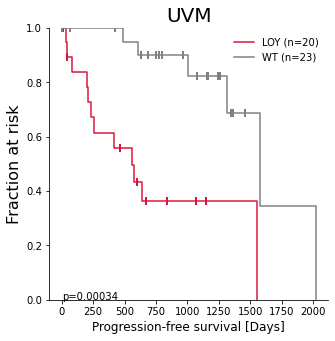

In [17]:
# Figure 4C
# KM plots for the three significant tumor types: MESO, UVM, PRAD

for ttype in ['MESO', 'PRAD', 'UVM']:
    PFS_time = TCGA_survival[TCGA_survival.type.isin([ttype])]['PFS.time']
    OS = TCGA_sample_info[TCGA_sample_info.type.isin([ttype])].OS
    status = TCGA_survival[TCGA_survival.type.isin([ttype])]['PFS']


    # Split (male) patients into low_Y and other - one patient not included due to NaN PFS_time, but is included in UVM clinical table?
    TCGA_LOY = PFS_time.loc[[x for x in PFS_time.index.values if x in LOY_samples]].dropna().index.values
    TCGA_wtY = PFS_time.loc[[x for x in PFS_time.index.values if x in wtY_samples]].dropna().index.values

    ## create a kmf object
    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    k1 = kmf.fit(PFS_time[TCGA_LOY], status[TCGA_LOY],label='LOY (n=' + str(len(PFS_time[TCGA_LOY]))+')')

    # plot first curve
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax = k1.plot(ci_show=False, color="crimson", show_censors=True, censor_styles={"marker": "|", "ms": 8, "mew":2}) 
    #ax = k1.plot(ci_show=False, color="crimson", show_censors=True) 
    ax.set_ylabel('Fraction at risk', fontsize=16)
    k2 = kmf.fit(PFS_time[TCGA_wtY].dropna(), status[TCGA_wtY].dropna(),label='WT (n=' + str(len(PFS_time[TCGA_wtY])) + ')')
    # plot second curve
    k2.plot(ax=ax, color='grey', ci_show=False, show_censors=True, censor_styles={"marker": "|", "ms": 8,  "mew":2})
    # log-rank test
    test = logrank_test(PFS_time[TCGA_LOY], PFS_time[TCGA_wtY], status[TCGA_LOY], status[TCGA_wtY], alpha=.99)
    test.print_summary()
    ax.text(5, 0.0, "p=" + str(round(test.p_value,5)))
    ax.set_xlabel('Progression-free survival [Days]', fontsize=12)
    ax.legend(loc='upper right', frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(ttype, fontsize=20)
    ax.set_ylim(0,1)
    plt.savefig(fig_dir + '/' + ttype + "_KM_" + time.strftime("%Y%m%d-%H%M%S")+ ".pdf")

